## Dataset

We will use tensorflow's `mnist` dataset, which allows us to classify handwritten numbers.

The `mnist` dataset has been separated into:
- 60,000 samples for training
- 10,000 samples for testing

## Feature

Each data has two features: `image`, `label`
- `image` has the class of `Image`, with the shape of (`x_pixel`, `y_pixel`, `color_channel`), e.g., (28, 28, 1), which means 28 by 28 pixel with the color channel of 1 meaning black and white.
  - The `color_channel` will be 3 if it is colored (3 stands for Red, Green, and Blue).

In [73]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import math
import matplotlib.pyplot as plt

In [74]:
# Load the `mnist` dataset from TensorFlow
data, metadata = tfds.load('mnist', as_supervised=True, with_info=True)

In [75]:
data

{'test': <_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'train': <_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

In [76]:
metadata

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/Users/sebastian/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [77]:
# Prepare the train and test data

data_train = data['train']
data_test = data['test']

In [78]:
data_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [79]:
metadata.features['label']

ClassLabel(shape=(), dtype=int64, num_classes=10)

In [80]:
# Check class names
class_names: list = metadata.features['label'].names
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [81]:
# Function to normalize the data
def normalizer(images, labels):
    # Convert the numbers from tf.int to tf.float32
    images = tf.cast(images, tf.float32)
    # Divide by 255 to make the data range from 0.0 to 1.0 instead of 0.0 to 255.0
    images = images / 255
    
    return images, labels

data_train = data_train.map(normalizer)
data_test = data_test.map(normalizer)

# Save data to cache to process faster from the second time on
data_train = data_train.cache()
data_test = data_test.cache()

In [82]:
# Create a new dataset that contains the first element from `data_train` using tensorflow's take function
first_element = data_train.take(1)

# Iterate over the first element to inspect it
for images, labels in first_element:
    # print(images, labels)
    break

2025-03-12 08:23:14.969249: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-03-12 08:23:14.969381: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


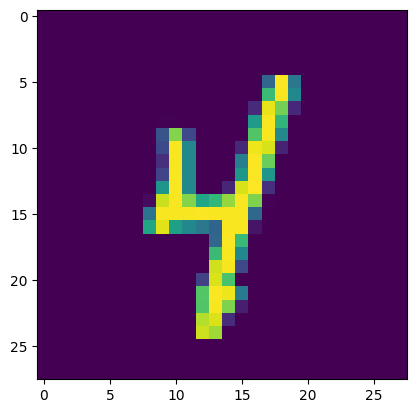

In [83]:
# Plotting a sample image

plt.figure()
plt.imshow(images)
plt.show()

In [84]:
images.shape

TensorShape([28, 28, 1])

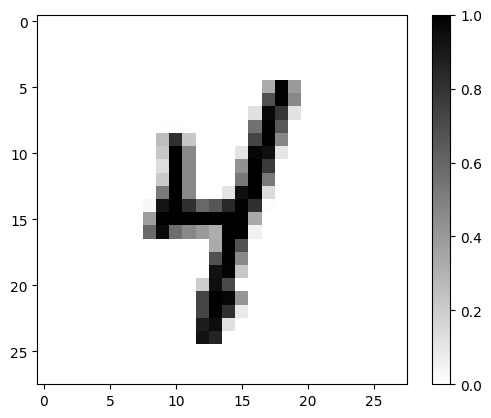

In [85]:
# Replot with to a grayscale image

plt.figure()
plt.imshow(images, cmap=plt.cm.binary)
plt.colorbar()
plt.show()

2025-03-12 08:23:15.369171: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-03-12 08:23:15.369298: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-03-12 08:23:15.372050: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence

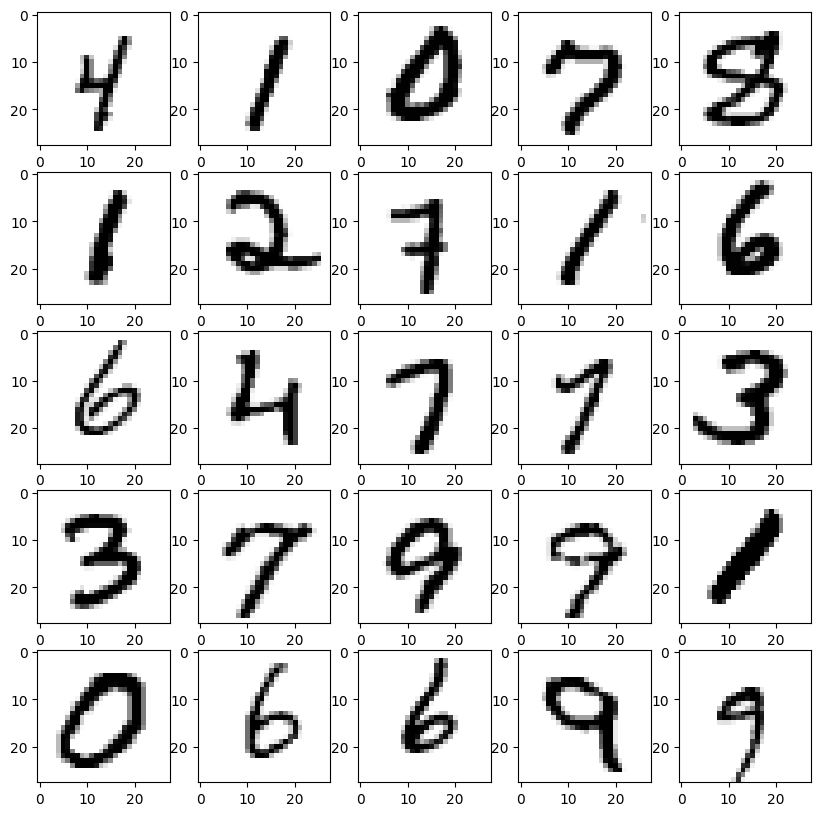

In [86]:
# Let's show the first 25 images
plt.figure(figsize=(10, 10))

for i, (images, labels) in enumerate(data_train.take(25)):
    plt.subplot(5, 5, i+1)
    plt.imshow(images, cmap=plt.cm.binary)

plt.show()

## Creating the model to train our data

Our data is of the shape (28, 28, 1), which is a 3D tensor. We will flatten this to a 1D tensor of shape (784,).

In [87]:
# Flatten the data to use it as the input feature in the first layer
flatten_data = keras.layers.Flatten(input_shape=(28,28,1))

/Users/sebastian/Improvement/ai/ai_practice/venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Create a model

### 1. Layers

We need to mix Convolutions, Pooling, and Dense layers to create a Convolutional Neural Network (CNN).

TONOTE: <span style="color:orange">Convolutional Layers</span> have the following features:
- shape: shape of 2D, as it's a two-dimensional image
- filters: number of filters to use. By default, start with `32`.
- kernel_size: size of the filter, which can be 3x3, 5x5, etc. By default, start with 3x3, which is `(3,3)`.
- input_shape: shape of the input data, which is (28, 28, 1) for our case.
- activation: activation function to use. By default, start with `relu` (Rectified Linear Unit).
- Example:
```python
tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1))
```

TONOTE: <span style="color:orange">Pooling Layers</span> have the following features:
- shape: shape of 2D, as it's a two-dimensional image
- pool_size: size of the pooling filter, which can be 2x2, 3x3, etc. By default, start with 2x2, which is `(2,2)`.
- Example:
```python
tf.keras.layers.MaxPooling2D(pool_size=(2,2))
```

TONOTE: The bigger the training images, the more convolutional and pooling layers should be put in. In our case of 28x28 pixel images, using the the convolutional and pooling layers twice is enough.

TONOTE: <span style="color:orange">Dense Layers</span> have the following features:
- Flatten: Flatten the input data to 1D tensor.
- units: number of neurons in the layer. We can start with `100` in the first dense layer with the activation function `relu`, and then `10` in the output layer with the activation function `softmax`.
- Example:
```python
tf.keras.layers.Dense(units=100, activation='relu')
tf.keras.layers.Dense(units=10, activation='softmax')
```

In [88]:
model = keras.Sequential([
    # Convolutional layer 1
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)),
    # Pooling layer 1
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    # Convolutional layer 2
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)),
    # Pooling layer 2
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    # Dense layer
    ## Flatten the layer
    keras.layers.Flatten(),
    ## Hidden layer
    keras.layers.Dense(units=100, activation='relu'),
    ## Output layer
    keras.layers.Dense(units=10, activation=tf.nn.softmax)
])

## 2. Compile the model

- Optimizer: `adam` or `tf.keras.optimizers.Adam()`
- Loss function: `sparse_categorical_crossentropy` or `tf.keras.losses.SparseCategoricalCrossentropy()`.
- Metrics: `accuracy` or `tf.keras.metrics.SparseCategoricalAccuracy()`.

In [89]:
model.compile(
    optimizer="adam",
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [90]:
# Check the length of data_train and data_test
print(f"Training Data Length: {len(data_train)}")
print(f"Testing Data Length: {len(data_test)}")

Training Data Length: 60000
Testing Data Length: 10000


## 3. Pre-process the data

- Pre-process the data - Create a batch size to train the model in a batch of `n` every time, instead of running one by one.

In [91]:
batch_size = 32

data_train = data_train.repeat().shuffle(60000).batch(batch_size)
data_test = data_test.batch(batch_size)

## 4. Train the model

- Train the model with the training data.
- Epochs: number of times to train the model with the training data. Start with `10`.
- Steps per epoch: number of batches to train the model with the training data. Since the total number of training data is 60,000, and the batch size is 32, the steps per epoch will be `60,000/32 = 1875`.

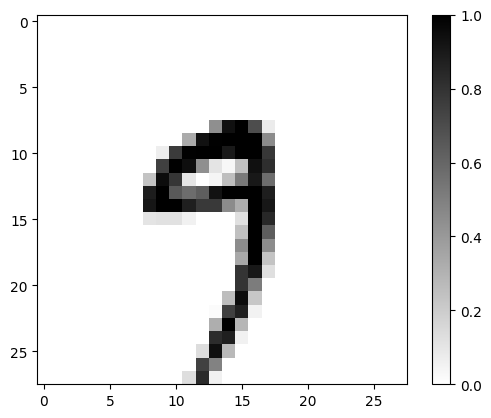

In [92]:
# First thing first, visualize the first image
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(images, cmap=plt.cm.binary) 
plt.colorbar()
plt.show()

In [93]:
# Train the model
history = model.fit(
    data_train, 
    epochs=10,
    steps_per_epoch=math.ceil(60000/batch_size)
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9040 - loss: 0.3170
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9843 - loss: 0.0494
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9887 - loss: 0.0360
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9923 - loss: 0.0249
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9947 - loss: 0.0183
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9950 - loss: 0.0148
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9961 - loss: 0.0127
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9972 - loss: 0.0097
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9977 - loss: 0.0074
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9973 - loss: 0.0077


Plot a grid with multiple predictions, respectively marking correct and incorrect ones as blue and red:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


2025-03-12 08:28:45.827776: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-03-12 08:28:45.827902: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Metadata: tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/Users/sebastian/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }

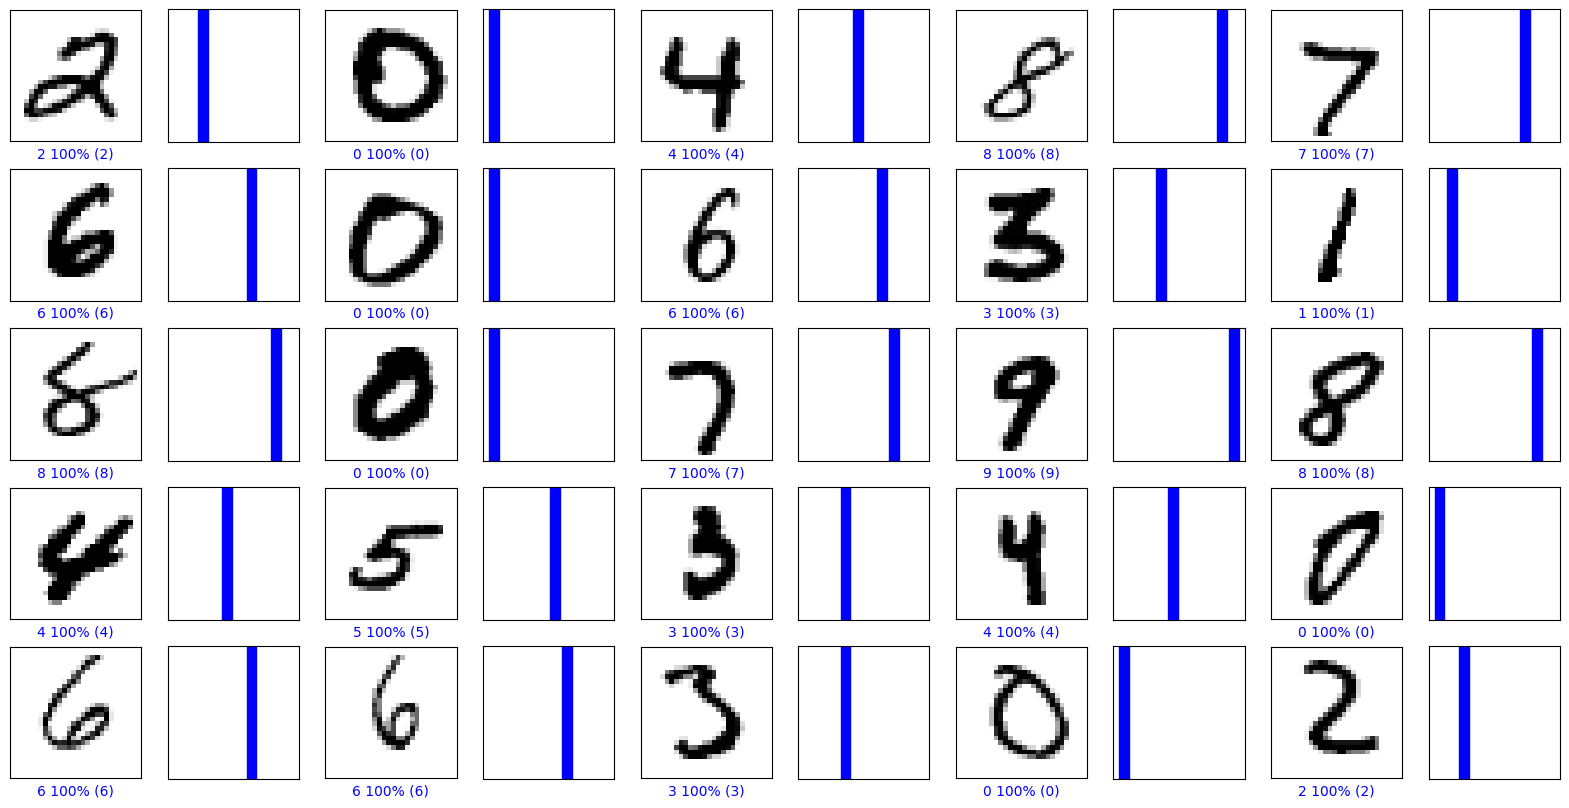

In [94]:
from matplotlib.container import BarContainer

# Get the first batch of test data for a quick inspection and make predictions, as testing the entire dataset is too time consuming
for images_test, labels_test in data_test.take(1):
    # Convert the images_test and labels_test from TensorFlow tensors into numpy arrays so that they can be easily used with Matplotlib
    images_test: np.ndarray = images_test.numpy()
    labels_test: np.ndarray = labels_test.numpy()
    #`images_test.shape` returns (32, 28, 28, 1), 32 is the batch_size, 28 is the height, 28 is the height, 1 is the color channel (grayscale). The shape already matches the one expected by `model.predict`, so we don't need to reshape it.
    predictions: np.ndarray = model.predict(images_test)
    
# Function to plot individual images with their predictions
def plot_image(i: int, predictions: np.ndarray, true_labels: np.ndarray, images: np.ndarray) -> None:
    # Extract data for the specific index
    prediction, true_label, image = predictions[i], true_labels[i], images[i]
    prediction: np.ndarray
    true_label: np.int64
    image: np.ndarray
    
    # Remove grid and axis ticks for cleaner visualization
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    # Display the image (only first channel as it's grayscale)
    plt.imshow(image[...,0], cmap=plt.cm.binary)
    
    # Use `np.argmax` to return the "index" of the maximum value in the `prediction` array
    predicted_label: np.int64 = np.argmax(prediction)
    
    # Set color for the predicted label: blue for correct predictions, red for incorrect
    color = 'blue' if predicted_label == true_label else 'red'
    
    print(f"Metadata: {metadata}")
    print(f"Metadata label: {metadata.features['label']}")
    print(f"Metadata label name: {metadata.features['label'].names}")
    
    # Add label showing: predicted digit, confidence percentage, and true digit
    plt.xlabel("{} {:2.0f}% ({})".format(
        class_names[predicted_label],
        100*np.max(prediction),
        class_names[true_label]
    ), color=color)

# Function to plot probability distribution for each prediction
def plot_value_array(i: int, predictions: np.ndarray, true_labels: np.ndarray) -> None:
    prediction, true_label = predictions[i], true_labels[i]
    prediction: np.ndarray
    true_label: np.int64
    
    # Remove grid and axis ticks
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    # Create bar chart of probability distribution (0-9)
    graph: BarContainer = plt.bar(range(10), prediction, color="#777777")
    # Set y-axis limit to 0-1 for probabilities
    plt.ylim([0,1])  
    
    predicted_label: np.int64 = np.argmax(prediction)
    
    # Highlight bars: red for prediction, blue for true label
    graph[predicted_label].set_color('red')
    graph[true_label].set_color('blue')
    
# Set up grid dimensions for visualization
num_row = 5
num_column = 5
num_images = num_row * num_column

# Create figure with subplots for both images and their probability distributions
plt.figure(figsize=(2*2*num_column, 2*num_row))
for i in range(num_images):
    plt.subplot(num_row, 2*num_column, 2*i+1)
    plot_image(i, predictions, labels_test, images_test)
    plt.subplot(num_row, 2*num_column, 2*i+2)
    plot_value_array(i, predictions, labels_test)